In [4]:
import pandas as pd 
import mlflow
import mlflow.sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

import numpy as np 
import subprocess
import json

In [5]:
df = pd.read_csv("data/creditcard.csv")

In [6]:
input_json = df.iloc[:80].drop(["Time", "Class"], axis=1).to_json(orient="split")

In [10]:
proc = subprocess.run(["curl",  "-X", "POST", "-H",
                       "Content-Type:application/json; format=pandas-split",
                       "--data", input_json, "http://127.0.0.1:1235/invocations"],
                      stdout=subprocess.PIPE, encoding='utf-8')


output = proc.stdout
df2 = pd.DataFrame([json.loads(output)])
df2

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31202  100   240  100 30962  10909  1374k --:--:-- --:--:-- --:--:-- 1385k


,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,1,0,1,1,1,0,0,1,1,0,...,1,0,0,0,0,0,1,1,0,0


In [11]:
y_true = df.iloc[:80].Class
df2 = df2.T
eval_acc = accuracy_score(y_true, df2)
y_true.iloc[-1] = 1
eval_auc = roc_auc_score(y_true, df2)
print("Eval Acc", eval_acc)
print("Eval AUC", eval_auc)

Eval Acc 0.6625
Eval AUC 0.3291139240506329


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [12]:
normal = df[df.Class == 0].sample(frac=0.5, random_state=2020).reset_index(drop=True)

anomaly = df[df.Class == 1]
normal_train, normal_test = train_test_split(normal,test_size = 0.2, random_state = 2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size = 0.2, random_state = 2020)
scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop(["Time", "Class"], axis=1))

StandardScaler()

In [13]:
scaled_selection = scaler.transform(df.iloc[:80].drop(["Time", "Class"], axis=1))
input_json = pd.DataFrame(scaled_selection).to_json(orient="split")


In [14]:
proc = subprocess.run(["curl", "-X", "POST", "-H", 
                       "Content-Type:application/json; format=pandas-split", 
                       "--data", input_json, "http://127.0.0.1:1235/invocations"], 
                      stdout=subprocess.PIPE, encoding='utf-8')
output = proc.stdout
preds = pd.DataFrame([json.loads(output)])
preds

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31760  100   240  100 31520  26666  3420k --:--:-- --:--:-- --:--:-- 3446k


,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
y_true = df.iloc[:80].Class
preds = preds.T
eval_acc = accuracy_score(y_true, preds)
y_true.iloc[-1] = 1
eval_auc = roc_auc_score(y_true, preds)
print("Eval Acc", eval_acc)
print("Eval AUC", eval_auc)

Eval Acc 0.9875
Eval AUC 0.5


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [20]:
test = df.iloc[:8000]
true = test.Class
test = scaler.transform(test.drop(["Time", "Class"], axis=1))
preds = []
batch_size = 80
for f in range(100):
    sample = pd.DataFrame(test[f*batch_size:(f+1)*batch_size]).to_json(orient="split")
    proc = subprocess.run(["curl",  "-X", "POST", "-H", "Content-Type:application/json; format=pandas-split", 
                           "--data", sample, "http://127.0.0.1:1235/invocations"],
                          stdout=subprocess.PIPE, encoding='utf-8')
                           
    output = proc.stdout
    resp = pd.DataFrame([json.loads(output)])
    preds = np.concatenate((preds, resp.values[0]))
                           
eval_acc = accuracy_score(true, preds)
eval_auc = roc_auc_score(true, preds)
print("Eval Acc", eval_acc)
print("Eval AUC", eval_auc)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31760  100   240  100 31520  26666  3420k --:--:-- --:--:-- --:--:-- 3446k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31771  100   240  100 31531  26666  3421k --:--:-- --:--:-- --:--:-- 3447k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31721  100   240  100 31481  26666  3415k --:--:-- --:--:-- --:--:-- 3441k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31805  100   240  100 31565  30000  3853k --:--:-- --:--:-- --:--:-- 3882k
  % Total    % Received % Xferd  Average Speed   Tim

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31820  100   240  100 31580  26666  3426k --:--:-- --:--:-- --:--:-- 3452k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31744  100   240  100 31504  26666  3418k --:--:-- --:--:-- --:--:-- 3444k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31754  100   240  100 31514  26666  3419k --:--:-- --:--:-- --:--:-- 3445k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31781  100   240  100 31541  30000  3850k --:--:-- --:--:-- --:--:-- 3879k
  % Total    % Received % Xferd  Average Speed   Tim

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31705  100   240  100 31465  26666  3414k --:--:-- --:--:-- --:--:-- 3440k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31704  100   240  100 31464  30000  3840k --:--:-- --:--:-- --:--:-- 3870k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31700  100   240  100 31460  30000  3840k --:--:-- --:--:-- --:--:-- 3869k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31707  100   240  100 31467  26666  3414k --:--:-- --:--:-- --:--:-- 3440k
  % Total    % Received % Xferd  Average Speed   Tim

Eval Acc 0.9995
Eval AUC 0.9230769230769231


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31763  100   240  100 31523  26666  3420k --:--:-- --:--:-- --:--:-- 3877k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31729  100   240  100 31489  30000  3843k --:--:-- --:--:-- --:--:-- 3873k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31765  100   240  100 31525  26666  3420k --:--:-- --:--:-- --:--:-- 3446k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31812  100   240  100 31572  30000  3854k --:--:-- --:--:-- --:--:-- 3883k


Text(0.5, 1.0, 'Confusion Matrix')

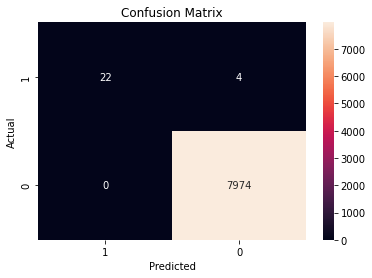

In [22]:
conf_matrix = confusion_matrix(true, preds)
ax = sns.heatmap(conf_matrix, annot=True,fmt='g') 
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix")